# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train_sam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 17            
model_seed = 7           

# --- Training configuration ---
epochs = 1500            

# --- Dataset configuration ---
base_data_size = 20      
dataset_type = "data"   
dataset_quantities = [0, 30, 80, 180, 380, 780]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train_sam(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


[SAM] Epoch 1/1500: Train Loss 0.6897 | Test Loss 0.6913 | accs Train 0.5500 Test 0.4943


[SAM] Epoch 100/1500: Train Loss 0.1468 | Test Loss 1.7623 | accs Train 0.9500 Test 0.5803


[SAM] Epoch 200/1500: Train Loss 0.0085 | Test Loss 4.0135 | accs Train 1.0000 Test 0.5687


[SAM] Epoch 300/1500: Train Loss 0.0022 | Test Loss 5.1798 | accs Train 1.0000 Test 0.5713


[SAM] Epoch 400/1500: Train Loss 0.0008 | Test Loss 6.1278 | accs Train 1.0000 Test 0.5737


[SAM] Epoch 500/1500: Train Loss 0.0004 | Test Loss 6.4297 | accs Train 1.0000 Test 0.5737


[SAM] Epoch 600/1500: Train Loss 0.0003 | Test Loss 6.7408 | accs Train 1.0000 Test 0.5735


[SAM] Epoch 700/1500: Train Loss 0.0002 | Test Loss 7.2617 | accs Train 1.0000 Test 0.5707


[SAM] Epoch 800/1500: Train Loss 0.0001 | Test Loss 7.5801 | accs Train 1.0000 Test 0.5705


[SAM] Epoch 900/1500: Train Loss 0.0001 | Test Loss 7.8183 | accs Train 1.0000 Test 0.5703


[SAM] Epoch 1000/1500: Train Loss 0.0001 | Test Loss 8.0340 | accs Train 1.0000 Test 0.5705


[SAM] Epoch 1100/1500: Train Loss 0.0001 | Test Loss 8.2249 | accs Train 1.0000 Test 0.5703


[SAM] Epoch 1200/1500: Train Loss 0.0000 | Test Loss 8.3846 | accs Train 1.0000 Test 0.5707


[SAM] Epoch 1300/1500: Train Loss 0.0000 | Test Loss 8.5391 | accs Train 1.0000 Test 0.5703


[SAM] Epoch 1400/1500: Train Loss 0.0000 | Test Loss 8.6836 | accs Train 1.0000 Test 0.5707


[SAM] Epoch 1500/1500: Train Loss 0.0000 | Test Loss 8.8070 | accs Train 1.0000 Test 0.5707
Completed training with 0 additional samples of data
[SAM] Epoch 1/1500: Train Loss 0.6914 | Test Loss 0.6915 | accs Train 0.5400 Test 0.4703


[SAM] Epoch 100/1500: Train Loss 0.4719 | Test Loss 0.6574 | accs Train 0.7600 Test 0.6360


[SAM] Epoch 200/1500: Train Loss 0.3575 | Test Loss 0.7380 | accs Train 0.8200 Test 0.6338


[SAM] Epoch 300/1500: Train Loss 0.1971 | Test Loss 1.0786 | accs Train 0.9400 Test 0.6663


[SAM] Epoch 400/1500: Train Loss 0.1109 | Test Loss 1.3766 | accs Train 0.9600 Test 0.6927


[SAM] Epoch 500/1500: Train Loss 0.0806 | Test Loss 1.5224 | accs Train 0.9600 Test 0.7057


[SAM] Epoch 600/1500: Train Loss 0.0567 | Test Loss 1.6012 | accs Train 0.9600 Test 0.7250


[SAM] Epoch 700/1500: Train Loss 0.0352 | Test Loss 1.6022 | accs Train 1.0000 Test 0.7785


[SAM] Epoch 800/1500: Train Loss 0.0143 | Test Loss 1.7100 | accs Train 1.0000 Test 0.7745


[SAM] Epoch 900/1500: Train Loss 0.0081 | Test Loss 1.6888 | accs Train 1.0000 Test 0.7788


[SAM] Epoch 1000/1500: Train Loss 0.0037 | Test Loss 1.6861 | accs Train 1.0000 Test 0.7873


[SAM] Epoch 1100/1500: Train Loss 0.0031 | Test Loss 1.6137 | accs Train 1.0000 Test 0.8057


[SAM] Epoch 1200/1500: Train Loss 0.0025 | Test Loss 1.5452 | accs Train 1.0000 Test 0.8100


[SAM] Epoch 1300/1500: Train Loss 0.0014 | Test Loss 1.6476 | accs Train 1.0000 Test 0.8117


[SAM] Epoch 1400/1500: Train Loss 0.0010 | Test Loss 1.7021 | accs Train 1.0000 Test 0.8147


[SAM] Epoch 1500/1500: Train Loss 0.0009 | Test Loss 1.7486 | accs Train 1.0000 Test 0.8067
Completed training with 30 additional samples of data
[SAM] Epoch 1/1500: Train Loss 0.6934 | Test Loss 0.6912 | accs Train 0.4700 Test 0.4778


[SAM] Epoch 100/1500: Train Loss 0.5238 | Test Loss 0.6245 | accs Train 0.6800 Test 0.6412


[SAM] Epoch 200/1500: Train Loss 0.2441 | Test Loss 0.5253 | accs Train 0.9500 Test 0.8090


[SAM] Epoch 300/1500: Train Loss 0.0444 | Test Loss 0.4259 | accs Train 1.0000 Test 0.9093


[SAM] Epoch 400/1500: Train Loss 0.0143 | Test Loss 0.4394 | accs Train 1.0000 Test 0.9257


[SAM] Epoch 500/1500: Train Loss 0.0081 | Test Loss 0.4372 | accs Train 1.0000 Test 0.9465


[SAM] Epoch 600/1500: Train Loss 0.0037 | Test Loss 0.4743 | accs Train 1.0000 Test 0.9437


[SAM] Epoch 700/1500: Train Loss 0.0025 | Test Loss 0.4919 | accs Train 1.0000 Test 0.9403


[SAM] Epoch 800/1500: Train Loss 0.0019 | Test Loss 0.4907 | accs Train 1.0000 Test 0.9463


[SAM] Epoch 900/1500: Train Loss 0.0014 | Test Loss 0.5118 | accs Train 1.0000 Test 0.9460


[SAM] Epoch 1000/1500: Train Loss 0.0012 | Test Loss 0.5087 | accs Train 1.0000 Test 0.9470


[SAM] Epoch 1100/1500: Train Loss 0.0007 | Test Loss 0.5310 | accs Train 1.0000 Test 0.9473


[SAM] Epoch 1200/1500: Train Loss 0.0005 | Test Loss 0.5438 | accs Train 1.0000 Test 0.9473


[SAM] Epoch 1300/1500: Train Loss 0.0003 | Test Loss 0.5607 | accs Train 1.0000 Test 0.9473


[SAM] Epoch 1400/1500: Train Loss 0.0009 | Test Loss 0.5290 | accs Train 1.0000 Test 0.9483


[SAM] Epoch 1500/1500: Train Loss 0.0006 | Test Loss 0.5510 | accs Train 1.0000 Test 0.9477
Completed training with 80 additional samples of data
[SAM] Epoch 1/1500: Train Loss 0.6936 | Test Loss 0.6911 | accs Train 0.5050 Test 0.5663


[SAM] Epoch 100/1500: Train Loss 0.5516 | Test Loss 0.6080 | accs Train 0.6850 Test 0.6512


[SAM] Epoch 200/1500: Train Loss 0.3236 | Test Loss 0.4025 | accs Train 0.8700 Test 0.8050


[SAM] Epoch 300/1500: Train Loss 0.0794 | Test Loss 0.1477 | accs Train 1.0000 Test 0.9775


[SAM] Epoch 400/1500: Train Loss 0.0248 | Test Loss 0.0882 | accs Train 1.0000 Test 0.9825


[SAM] Epoch 500/1500: Train Loss 0.0090 | Test Loss 0.0691 | accs Train 1.0000 Test 0.9835


[SAM] Epoch 600/1500: Train Loss 0.0061 | Test Loss 0.0709 | accs Train 1.0000 Test 0.9832


[SAM] Epoch 700/1500: Train Loss 0.0031 | Test Loss 0.0768 | accs Train 1.0000 Test 0.9822


[SAM] Epoch 800/1500: Train Loss 0.0021 | Test Loss 0.0877 | accs Train 1.0000 Test 0.9805


[SAM] Epoch 900/1500: Train Loss 0.0015 | Test Loss 0.0951 | accs Train 1.0000 Test 0.9802


[SAM] Epoch 1000/1500: Train Loss 0.0010 | Test Loss 0.1007 | accs Train 1.0000 Test 0.9800


[SAM] Epoch 1100/1500: Train Loss 0.0007 | Test Loss 0.1054 | accs Train 1.0000 Test 0.9802


[SAM] Epoch 1200/1500: Train Loss 0.0056 | Test Loss 0.0682 | accs Train 1.0000 Test 0.9830


[SAM] Epoch 1300/1500: Train Loss 0.0023 | Test Loss 0.0779 | accs Train 1.0000 Test 0.9830


[SAM] Epoch 1400/1500: Train Loss 0.0016 | Test Loss 0.0838 | accs Train 1.0000 Test 0.9818


[SAM] Epoch 1500/1500: Train Loss 0.0012 | Test Loss 0.0864 | accs Train 1.0000 Test 0.9818
Completed training with 180 additional samples of data
[SAM] Epoch 1/1500: Train Loss 0.6940 | Test Loss 0.6911 | accs Train 0.4825 Test 0.5777


[SAM] Epoch 100/1500: Train Loss 0.5699 | Test Loss 0.5912 | accs Train 0.6475 Test 0.6462


[SAM] Epoch 200/1500: Train Loss 0.2830 | Test Loss 0.3217 | accs Train 0.9175 Test 0.8682


[SAM] Epoch 300/1500: Train Loss 0.0716 | Test Loss 0.1221 | accs Train 1.0000 Test 0.9750


[SAM] Epoch 400/1500: Train Loss 0.0166 | Test Loss 0.0758 | accs Train 1.0000 Test 0.9775


[SAM] Epoch 500/1500: Train Loss 0.0091 | Test Loss 0.0778 | accs Train 1.0000 Test 0.9752


[SAM] Epoch 600/1500: Train Loss 0.0031 | Test Loss 0.0717 | accs Train 1.0000 Test 0.9770


[SAM] Epoch 700/1500: Train Loss 0.0050 | Test Loss 0.0684 | accs Train 1.0000 Test 0.9798


[SAM] Epoch 800/1500: Train Loss 0.0021 | Test Loss 0.0653 | accs Train 1.0000 Test 0.9808


[SAM] Epoch 900/1500: Train Loss 0.0015 | Test Loss 0.0704 | accs Train 1.0000 Test 0.9788


[SAM] Epoch 1000/1500: Train Loss 0.0011 | Test Loss 0.0734 | accs Train 1.0000 Test 0.9785


[SAM] Epoch 1100/1500: Train Loss 0.0009 | Test Loss 0.0760 | accs Train 1.0000 Test 0.9785


[SAM] Epoch 1200/1500: Train Loss 0.0007 | Test Loss 0.0777 | accs Train 1.0000 Test 0.9785


[SAM] Epoch 1300/1500: Train Loss 0.0006 | Test Loss 0.0796 | accs Train 1.0000 Test 0.9785


[SAM] Epoch 1400/1500: Train Loss 0.0005 | Test Loss 0.0813 | accs Train 1.0000 Test 0.9785


[SAM] Epoch 1500/1500: Train Loss 0.0004 | Test Loss 0.0826 | accs Train 1.0000 Test 0.9785
Completed training with 380 additional samples of data
[SAM] Epoch 1/1500: Train Loss 0.6947 | Test Loss 0.6912 | accs Train 0.4750 Test 0.5830


[SAM] Epoch 100/1500: Train Loss 0.5799 | Test Loss 0.5769 | accs Train 0.6062 Test 0.6198


[SAM] Epoch 200/1500: Train Loss 0.2821 | Test Loss 0.2946 | accs Train 0.9537 Test 0.9400


[SAM] Epoch 300/1500: Train Loss 0.0572 | Test Loss 0.0748 | accs Train 0.9975 Test 0.9900


[SAM] Epoch 400/1500: Train Loss 0.0193 | Test Loss 0.0342 | accs Train 0.9975 Test 0.9925


[SAM] Epoch 500/1500: Train Loss 0.0078 | Test Loss 0.0218 | accs Train 1.0000 Test 0.9945


[SAM] Epoch 600/1500: Train Loss 0.0082 | Test Loss 0.0253 | accs Train 1.0000 Test 0.9945


[SAM] Epoch 700/1500: Train Loss 0.0047 | Test Loss 0.0165 | accs Train 1.0000 Test 0.9952


[SAM] Epoch 800/1500: Train Loss 0.0029 | Test Loss 0.0148 | accs Train 1.0000 Test 0.9952


[SAM] Epoch 900/1500: Train Loss 0.0020 | Test Loss 0.0141 | accs Train 1.0000 Test 0.9955


[SAM] Epoch 1000/1500: Train Loss 0.0015 | Test Loss 0.0135 | accs Train 1.0000 Test 0.9958


[SAM] Epoch 1100/1500: Train Loss 0.0011 | Test Loss 0.0134 | accs Train 1.0000 Test 0.9960


[SAM] Epoch 1200/1500: Train Loss 0.0007 | Test Loss 0.0131 | accs Train 1.0000 Test 0.9960


[SAM] Epoch 1300/1500: Train Loss 0.0005 | Test Loss 0.0123 | accs Train 1.0000 Test 0.9960


[SAM] Epoch 1400/1500: Train Loss 0.0021 | Test Loss 0.0115 | accs Train 1.0000 Test 0.9962


[SAM] Epoch 1500/1500: Train Loss 0.0017 | Test Loss 0.0069 | accs Train 1.0000 Test 0.9980
Completed training with 780 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 8.8070 | accs: 0.5707
  30 samples | Test Loss: 1.7486 | accs: 0.8067
  80 samples | Test Loss: 0.5510 | accs: 0.9477
 180 samples | Test Loss: 0.0864 | accs: 0.9818
 380 samples | Test Loss: 0.0826 | accs: 0.9785
 780 samples | Test Loss: 0.0069 | accs: 0.9980

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model   30 | Train Loss: 0.0004 | accs: 1.0000
 Model   80 | Train Loss: 0.0005 | accs: 1.0000
 Model  180 | Train Loss: 0.0008 | accs: 1.0000
 Model  380 | Train Loss: 0.0003 | accs: 1.0000
 Model  780 | Train Loss: 0.0013 | accs: 1.0000

Dataset type: data, additional samples: 30
 Model    0 | Train Loss: 4.9465 | accs: 0.8000
 Model   30 | Train Loss: 0.0009 | accs: 1.0000
 Model   80 | Train Loss: 0.0006 | accs: 1.0000
 Model  180 | Train Loss: 0.0010 | accs: 1.0000
 Model  380 | Train Loss: 0.0003 | accs: 1.0000
 Model  780 | Train Loss:

### Model + Data Specific Verification

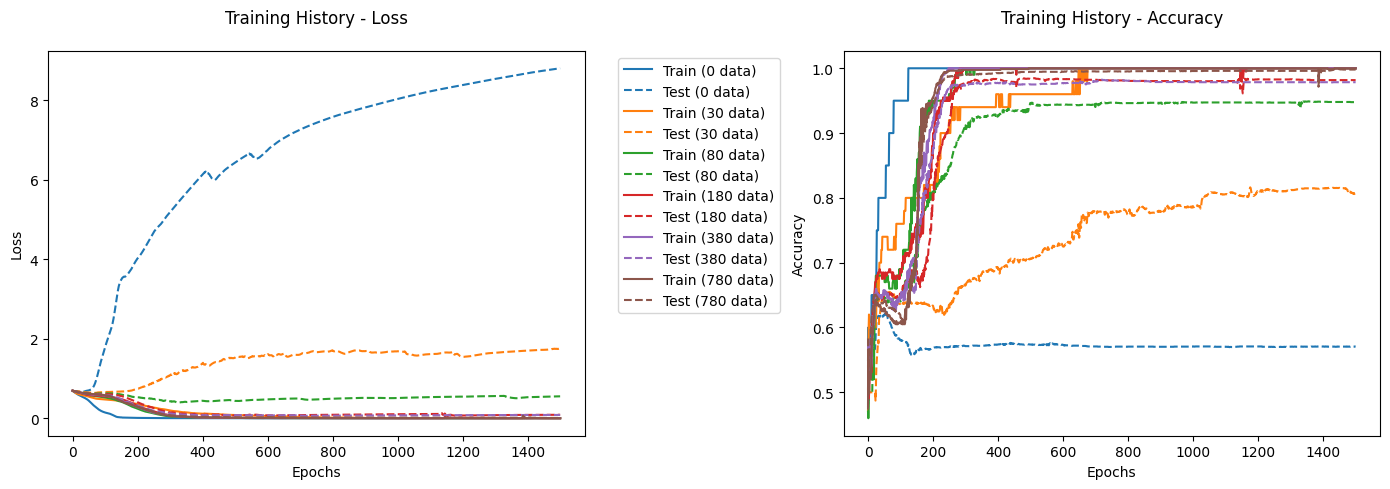

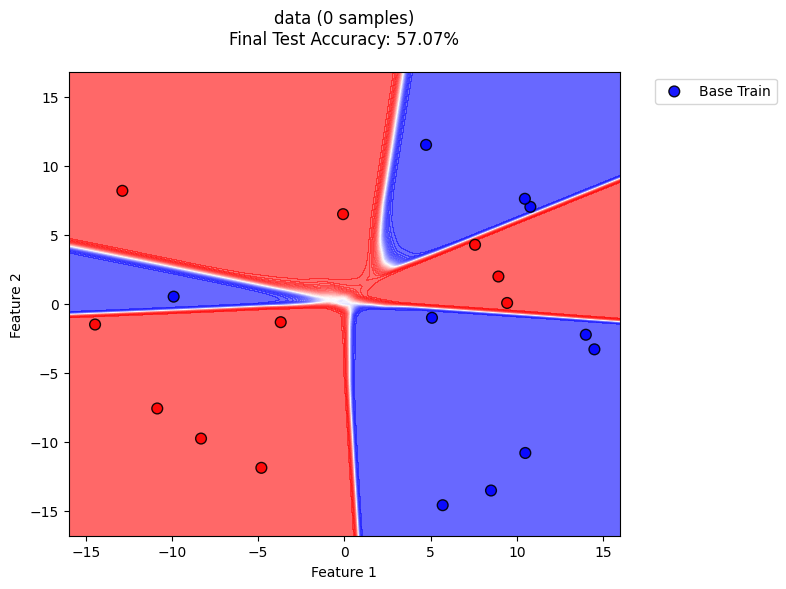

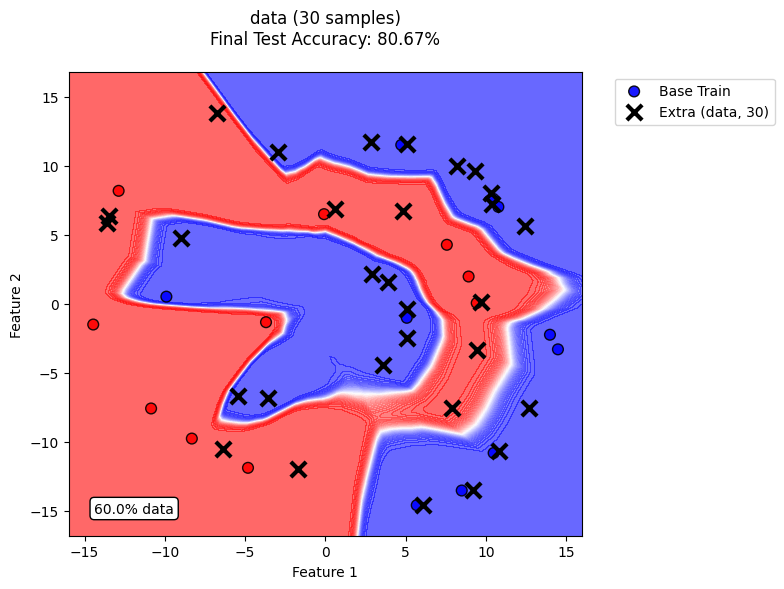

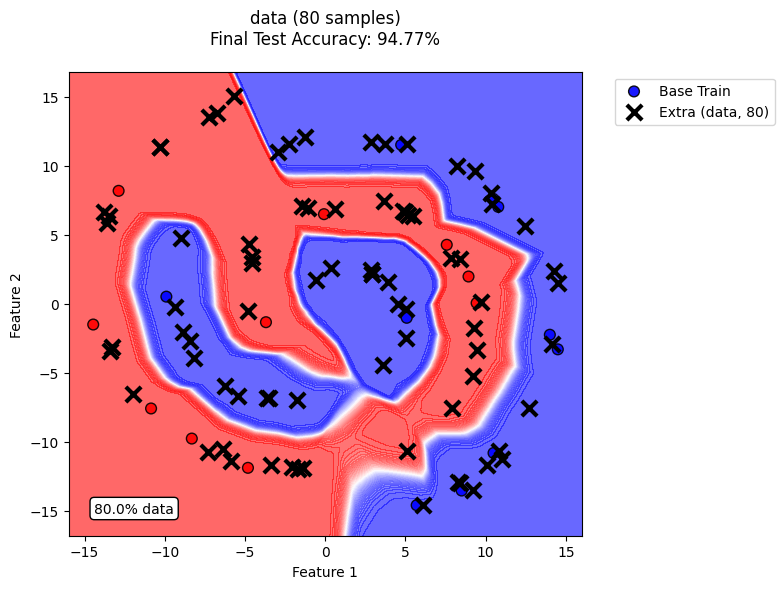

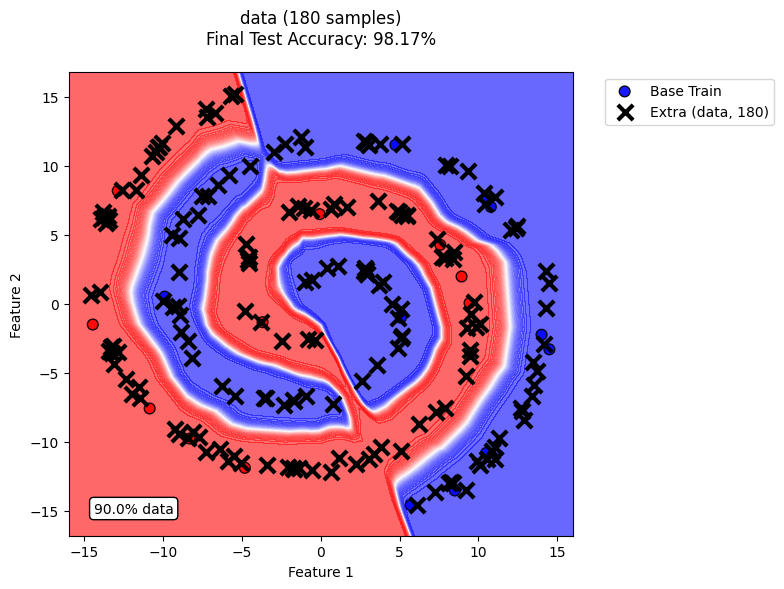

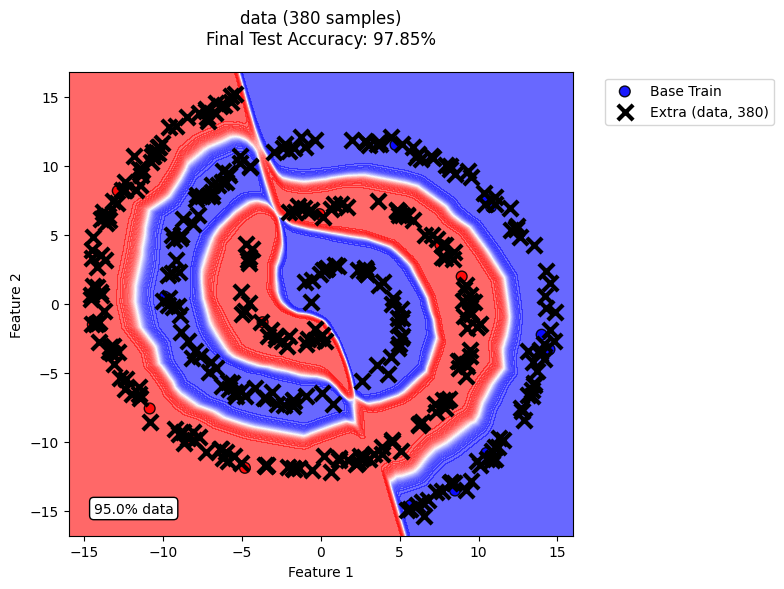

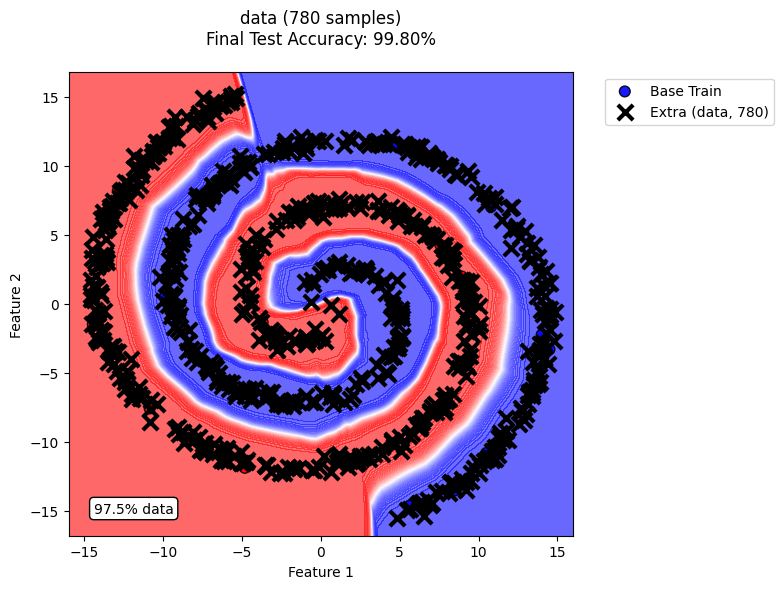

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_30.pt
Saved model: models_and_data/model_additional_30.pt
✅ Model saved to models_and_data\model_additional_80.pt
Saved model: models_and_data/model_additional_80.pt
✅ Model saved to models_and_data\model_additional_180.pt
Saved model: models_and_data/model_additional_180.pt
✅ Model saved to models_and_data\model_additional_380.pt
Saved model: models_and_data/model_additional_380.pt
✅ Model saved to models_and_data\model_additional_780.pt
Saved model: models_and_data/model_additional_780.pt
